## Decimation exercise

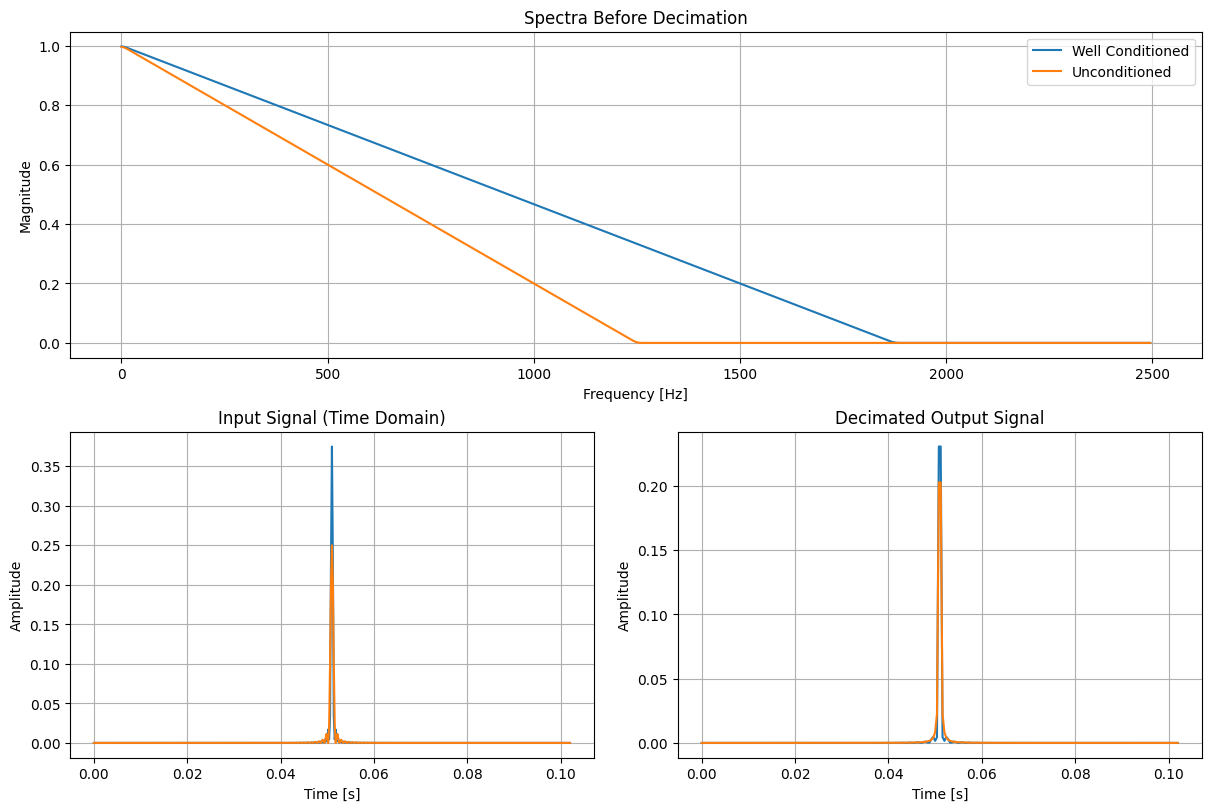

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg
import scipy.fft as sf


Nf = 512  # Number of frequency points
fs = 5000
t = np.arange(Nf - 1) / fs  # Matches firwin2(Nf - 1)

f = [0, 0.25, 0.5, 0.75, 1]
a1 = [1, 0.6667, 0.3333, 0, 0]
a2 = [1.0000, 0.5000, 0, 0, 0]

input_signal_1 = sg.firwin2(Nf - 1, f, a1)
input_signal_2 = sg.firwin2(Nf - 1, f, a2)


# Frequency response of original signals
w, H1 = sg.freqz(input_signal_1, 1, worN=Nf, fs=fs)
_, H2 = sg.freqz(input_signal_2, 1, worN=Nf, fs=fs)

# DECIMATION
P = 2  # Decimation factor
output_signal_1 = input_signal_1[::P]
output_signal_2 = input_signal_2[::P]
to = t[::P]  # decimated time vector

# Plot spectra and time-domain before/after decimation
fig = plt.figure(figsize=(12, 8), layout='constrained')
axs = fig.subplot_mosaic([['spectrum', 'spectrum'], ['input', 'output']])

axs['spectrum'].set_title("Spectra Before Decimation")
axs['spectrum'].plot(w, np.abs(H1), label="Well Conditioned", color='C0')
axs['spectrum'].plot(w, np.abs(H2), label="Unconditioned", color='C1')
axs['spectrum'].set_xlabel("Frequency [Hz]")
axs['spectrum'].set_ylabel("Magnitude")
axs['spectrum'].legend()
axs['spectrum'].grid(True)

axs['input'].set_title("Input Signal (Time Domain)")
axs['input'].plot(t, input_signal_1, label="Well", color='C0')
axs['input'].plot(t, input_signal_2, label="Unconditioned", color='C1')
axs['input'].set_xlabel("Time [s]")
axs['input'].set_ylabel("Amplitude")
axs['input'].grid(True)

axs['output'].set_title("Decimated Output Signal")
axs['output'].plot(to, output_signal_1, label="Well ↓2", color='C0')
axs['output'].plot(to, output_signal_2, label="Unconditioned ↓2", color='C1')
axs['output'].set_xlabel("Time [s]")
axs['output'].set_ylabel("Amplitude")
axs['output'].grid(True)

plt.show()


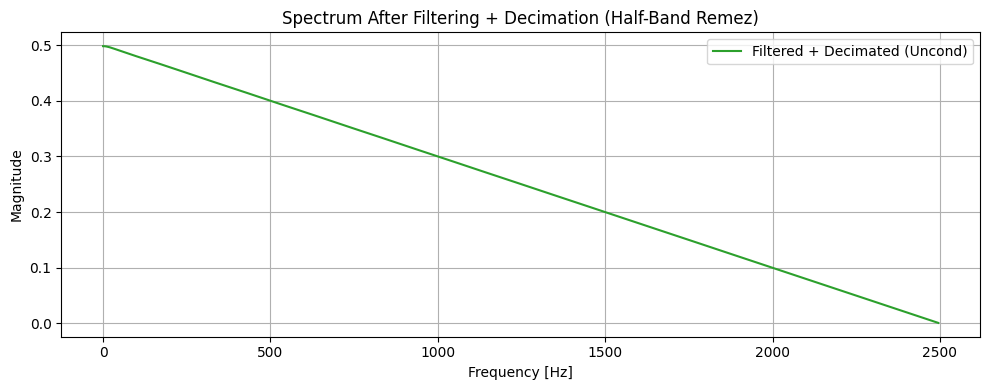

In [7]:
# Half-band FIR filter via Remez
numtaps = 101
cutoff = fs / 4         # 1250 Hz
transition = 200        # 200 Hz transition width

bands = [0, cutoff, cutoff + transition, fs / 2]
desired = [1, 0]
weights = [1, 1]

halfband_filter = sg.remez(numtaps, bands, desired, weight=weights, fs=fs)
# Filter and decimate unconditioned signal
filtered_uncond = sg.lfilter(halfband_filter, 1.0, input_signal_2)
output_filtered = filtered_uncond[::P]

# Plot spectrum
w, Hfilt = sg.freqz(output_filtered, 1, worN=Nf, fs=fs)

plt.figure(figsize=(10, 4))
plt.plot(w, np.abs(Hfilt), label="Filtered + Decimated (Uncond)", color='C2')
plt.title("Spectrum After Filtering + Decimation (Half-Band Remez)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

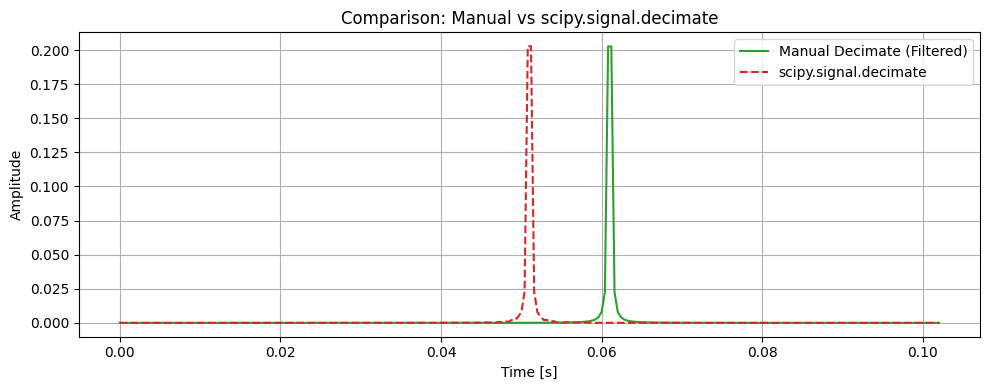

In [8]:
from scipy.signal import decimate

output_decimate = decimate(input_signal_2, P, ftype='fir')

# Plot comparison
plt.figure(figsize=(10, 4))
plt.plot(to, output_filtered[:len(to)], label="Manual Decimate (Filtered)", color='C2')
plt.plot(to[:len(output_decimate)], output_decimate, label="scipy.signal.decimate", linestyle='--', color='C3')
plt.title("Comparison: Manual vs scipy.signal.decimate")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## Interpolation exercise

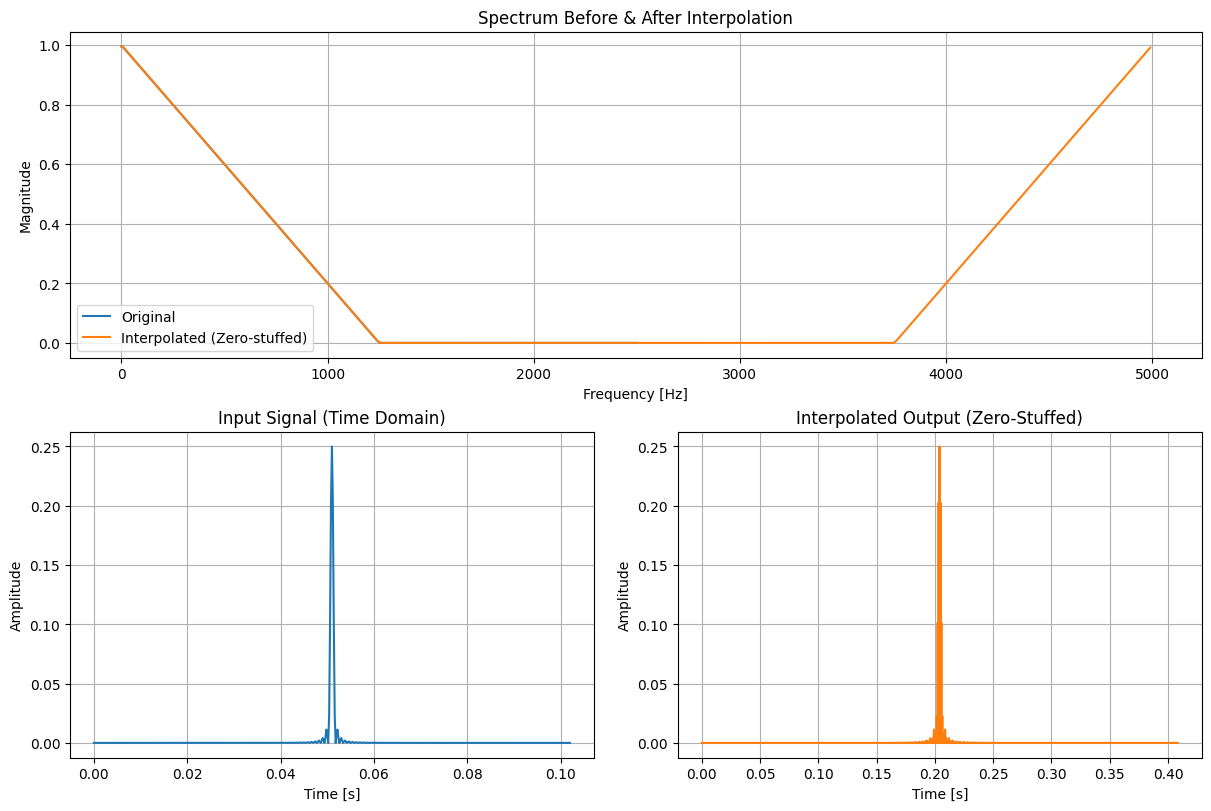

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg

# Step 1: Original signal (triangle spectrum)
f_spec = [0, 0.25, 0.5, 0.75, 1]
a_spec = [1.0, 0.5, 0, 0, 0]
Nf = 512
fs = 5000
Q = 2  # interpolation factor

# Time base
input_signal = sg.firwin2(Nf - 1, f_spec, a_spec)
t_in = np.arange(len(input_signal)) / fs

# Step 2: Interpolate (zero-insertion)
output_signal = np.zeros(len(input_signal) * Q)
output_signal[::Q] = input_signal
t_out = np.arange(len(output_signal)) / (fs * Q**-1)

# Step 3: Plot frequency and time domains
w1, H1 = sg.freqz(input_signal, 1, worN=Nf, fs=fs)
w2, H2 = sg.freqz(output_signal, 1, worN=Nf, fs=fs*Q)

fig = plt.figure(figsize=(12, 8), layout='constrained')
axs = fig.subplot_mosaic([["spectrum", "spectrum"], ["input", "output"]])

axs["spectrum"].set_title("Spectrum Before & After Interpolation")
axs["spectrum"].plot(w1, np.abs(H1), label="Original", color="C0")
axs["spectrum"].plot(w2, np.abs(H2), label="Interpolated (Zero-stuffed)", color="C1")
axs["spectrum"].set_xlabel("Frequency [Hz]")
axs["spectrum"].set_ylabel("Magnitude")
axs["spectrum"].legend()
axs["spectrum"].grid()

axs["input"].set_title("Input Signal (Time Domain)")
axs["input"].plot(t_in, input_signal, color="C0")
axs["input"].set_xlabel("Time [s]")
axs["input"].set_ylabel("Amplitude")
axs["input"].grid()

axs["output"].set_title("Interpolated Output (Zero-Stuffed)")
axs["output"].plot(t_out, output_signal, color="C1")
axs["output"].set_xlabel("Time [s]")
axs["output"].set_ylabel("Amplitude")
axs["output"].grid()

plt.show()


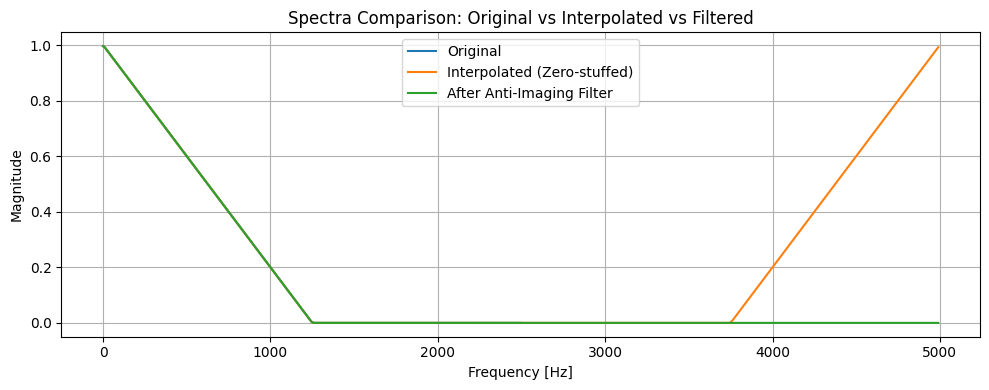

In [2]:
# Anti-imaging filter (LPF)
numtaps = 101
cutoff = fs / 2 / Q  # Nyquist / Q = 1250 Hz
bands = [0, cutoff, cutoff + 500, fs / 2 * Q]  # up to new Nyquist
desired = [1, 0]
weights = [1, 1]

anti_imaging_filter = sg.remez(numtaps, bands, desired, weight=weights, fs=fs * Q)

# Filter interpolated signal
filtered_output = sg.lfilter(anti_imaging_filter, 1.0, output_signal)

# Plot frequency response after filtering
w3, H3 = sg.freqz(filtered_output, 1, worN=Nf, fs=fs * Q)

plt.figure(figsize=(10, 4))
plt.plot(w1, np.abs(H1), label="Original", color="C0")
plt.plot(w2, np.abs(H2), label="Interpolated (Zero-stuffed)", color="C1")
plt.plot(w3, np.abs(H3), label="After Anti-Imaging Filter", color="C2")
plt.title("Spectra Comparison: Original vs Interpolated vs Filtered")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


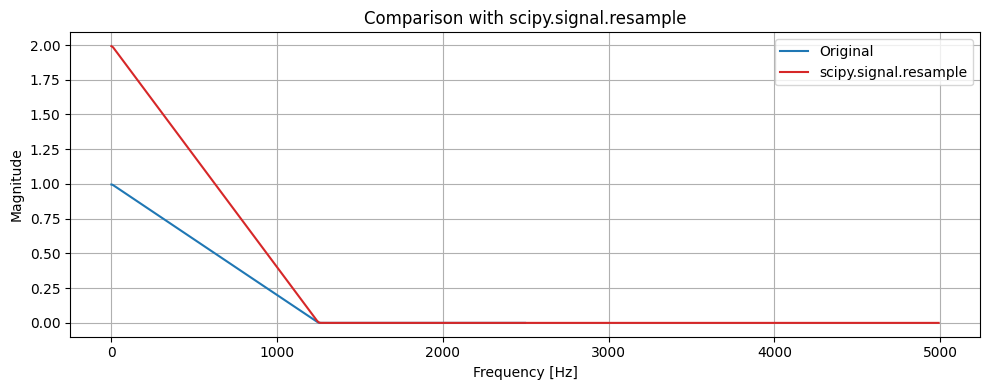

In [3]:
from scipy.signal import resample

# Interpolation using FFT-based resample
resampled_signal = resample(input_signal, len(output_signal))

# Spectrum of resampled
w4, H4 = sg.freqz(resampled_signal, 1, worN=Nf, fs=fs * Q)

plt.figure(figsize=(10, 4))
plt.plot(w1, np.abs(H1), label="Original", color='C0')
plt.plot(w4, np.abs(H4), label="scipy.signal.resample", color='C3')
plt.title("Comparison with scipy.signal.resample")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## Rational resapling

In [5]:
from fractions import Fraction
Fraction(96000, 44100).limit_denominator()

Fraction(320, 147)

In [6]:
from scipy.io import wavfile
fs_in, audio = wavfile.read("4ch.wav")

# Normalize if integer data
if audio.dtype != np.float32:
    audio = audio / np.iinfo(audio.dtype).max

# Mono if stereo
if audio.ndim == 2:
    audio = audio.mean(axis=1)

print(f"Original sample rate: {fs_in}, shape: {audio.shape}")


Original sample rate: 44100, shape: (169031,)


In [7]:
from scipy.signal import remez, upfirdn

# Rational approximation: upsample by 320, downsample by 147
L = 320
M = 147

fs_out = fs_in * L / M
print(f"Target sample rate: {fs_out:.2f} Hz")


Target sample rate: 96000.00 Hz


In [8]:
numtaps = 511
fc = 0.5 * min(fs_in / L, fs_out / M)  # conservative cutoff

bands = [0, fc, fc + 1000, 0.5 * fs_in]
desired = [1, 0]
weights = [1, 10]

filt = remez(numtaps, bands, desired, weight=weights, fs=fs_in)


In [9]:
pad = L - (len(filt) % L)
if pad != L:
    filt = np.concatenate([filt, np.zeros(pad)])


In [10]:
# Polyphase resampling: upsample, filter, downsample
resampled = upfirdn(filt, audio, up=L, down=M)


In [11]:
from scipy.signal import resample_poly

reference = resample_poly(audio, up=L, down=M)


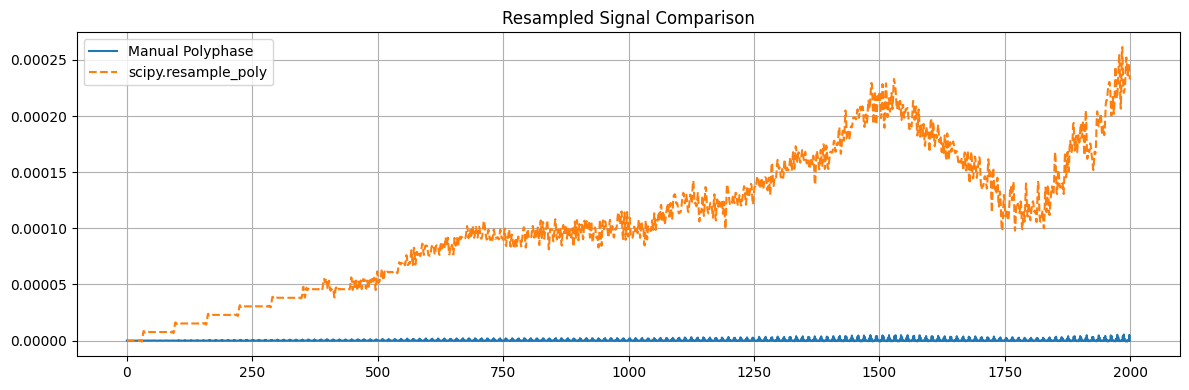

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(resampled[:2000], label="Manual Polyphase")
plt.plot(reference[:2000], '--', label="scipy.resample_poly")
plt.legend()
plt.title("Resampled Signal Comparison")
plt.grid()
plt.tight_layout()
plt.show()


In [13]:
from scipy.io.wavfile import write
write("resampled_polyphase.wav", int(fs_out), (resampled * 32767).astype(np.int16))
write("resampled_reference.wav", int(fs_out), (reference * 32767).astype(np.int16))
